In [25]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [26]:
path = '/mnt/hdd/Workspace/MP_pipeline_Aug13/normal_mp'
#filename = 'P4637_2024_10_11_15_48_16.csv'
filename = 'P4637_2024_10_12_14_39_25.csv'
file_path = os.path.join(path, filename)
df = pd.read_csv(file_path)

In [27]:
print(df)

     max_trials     mode   repeat_wrong   win_delays   lose_delays  \
0           inf   Mode 2              0            0             0   
1           inf   Mode 2              0            0             0   
2           inf   Mode 2              0            0             0   
3           inf   Mode 2              0            0             0   
4           inf   Mode 2              0            0             0   
..          ...      ...            ...          ...           ...   
310         inf   Mode 2              0            0             0   
311         inf   Mode 2              0            0             0   
312         inf   Mode 2              0            0             0   
313         inf   Mode 2              0            0             0   
314         inf   Mode 2              0            0             0   

      L_win_L_delay   L_lose_L_delay   R_win_L_delay   R_lose_L_delay  \
0                 0                0               0                0   
1            

In [28]:
colnames = df.columns.tolist()
print(df.columns)
print(colnames[10])
df.columns[1].lower()

Index(['max_trials', ' mode', ' repeat_wrong', ' win_delays', ' lose_delays',
       ' L_win_L_delay', ' L_lose_L_delay', ' R_win_L_delay',
       ' R_lose_L_delay', ' R_win_R_delay',
       ...
       ' R_light_off_ts', ' L_light_off_ts', ' choices', ' performance',
       ' L_clicks', ' R_clicks', ' error_id', ' error_string',
       ' house_light_on_ts', ' R_reward_ts'],
      dtype='object', length=123)
 R_lose_R_delay


' mode'

In [29]:
def find_columns(df, search_term=""):
    """Find columns containing search term"""
    if search_term:
        matches = [col for col in df.columns if search_term.lower() in col.lower()]
        print(f"Columns containing '{search_term}':")
        for col in matches:
            print(f"  - {col}")
        return matches
    else:
        return df.columns.tolist()

# Usage
find_columns(df, "lose")
find_columns(df, "R_lose_R_delay")

Columns containing 'lose':
  -  lose_delays
  -  L_lose_L_delay
  -  R_lose_L_delay
  -  R_lose_R_delay
  -  L_lose_R_delay
Columns containing 'R_lose_R_delay':
  -  R_lose_R_delay


[' R_lose_R_delay']

In [30]:
matches = find_columns(df, "well")
ratchoice = df[" well_id"]

comchoice = df[" rewarded_well"]
print(type(comchoice), type(ratchoice), type(matches), len(comchoice), len(ratchoice))
#df[matches[4]]

Columns containing 'well':
  -  well_error
  -  well_timeout
  -  debounce_down_well
  -  rewarded_well
  -  L_well_on_stim
  -  L_well_off_stim
  -  R_well_on_stim
  -  R_well_off_stim
  -  well_timeout_stim
  -  well_early_go_stim
  -  L_well_on_stim_delay
  -  L_well_off_stim_delay
  -  R_well_on_stim_delay
  -  R_well_off_stim_delay
  -  well_timeout_stim_delay
  -  well_early_go_stim_delay
  -  L_well_all_on_ts
  -  L_well_all_off_ts
  -  R_well_all_on_ts
  -  R_well_all_off_ts
  -  well_id
  -  well_on_ts
  -  well_off_ts
  -  well_early_go_flg
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'> <class 'list'> 315 315


In [31]:
wins = (ratchoice==comchoice).astype(int)
print(wins)
print(sum(wins==1)/len(wins))

0      0
1      0
2      1
3      1
4      1
      ..
310    1
311    1
312    0
313    0
314    0
Length: 315, dtype: int64
0.49206349206349204


In [32]:
def calculate_win_stay(ratchoice, wins):
    prev_wins = wins.shift(1)
    stayed = ratchoice == ratchoice.shift(1)
    win_stay = (prev_wins==1) & stayed
    return win_stay.astype(int)

winstay = calculate_win_stay(ratchoice, wins)
print(winstay, ratchoice, comchoice)

0      0
1      0
2      0
3      1
4      0
      ..
310    0
311    1
312    1
313    0
314    0
Length: 315, dtype: int64 0       L
1       L
2       R
3       R
4       L
       ..
310     R
311     R
312     R
313     R
314      
Name:  well_id, Length: 315, dtype: object 0       E
1       R
2       R
3       R
4       L
       ..
310     R
311     R
312     L
313     L
314     L
Name:  rewarded_well, Length: 315, dtype: object


In [33]:
# More concise version
ratchoice = df[" well_id"]

comchoice = df[" rewarded_well"]
df['wins'] = (ratchoice==comchoice).astype(int)
df['win_stay'] = ((df['wins'].shift(1) == 1) & 
                  (df[' well_id'] == df[' well_id'].shift(1))).astype(int)

print(f"Win-stay instances: {df['win_stay'].sum()}")
print(f"Total opportunities for win-stay: {(df['wins'].shift(1) == 1).sum()}")

Win-stay instances: 78
Total opportunities for win-stay: 155


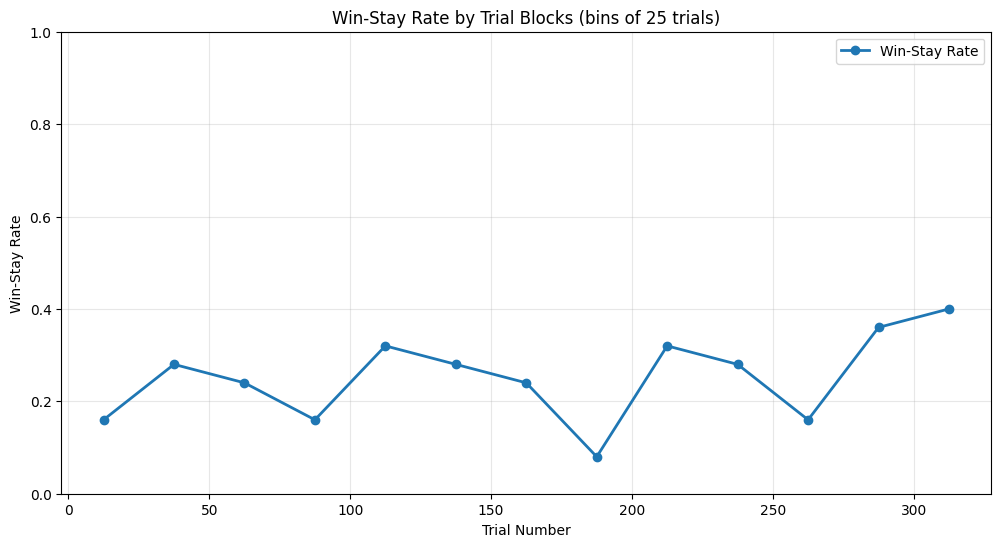

In [34]:
# Group trials into bins and calculate win-stay rate for each bin
bin_size = 25  # Trials per bin
df['trial_bin'] = df.index // bin_size

bin_stats = df.groupby('trial_bin').agg({
    'win_stay': ['sum', 'count', 'mean'],
    'wins': 'mean'  # Also plot win rate for comparison
}).round(3)

bin_stats.columns = ['win_stay_count', 'total_trials', 'win_stay_rate', 'win_rate']

plt.figure(figsize=(12, 6))
x_pos = bin_stats.index * bin_size + bin_size/2  # Center of each bin

plt.plot(x_pos, bin_stats['win_stay_rate'], marker='o', linewidth=2, markersize=6, label='Win-Stay Rate')
plt.title(f'Win-Stay Rate by Trial Blocks (bins of {bin_size} trials)')
plt.xlabel('Trial Number')
plt.ylabel('Win-Stay Rate')
plt.grid(True, alpha=0.3)
plt.legend()
plt.ylim(0, 1)
plt.show()

In [35]:
print(df['trial_bin'])

0       0
1       0
2       0
3       0
4       0
       ..
310    12
311    12
312    12
313    12
314    12
Name: trial_bin, Length: 315, dtype: int64
